### Importing Libraries

In [1]:
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, Variable, ParticleFile
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import math

### Verifying the structure and dimentions of the data files

In [2]:
# Open the SSC dataset
ssc_ds = xr.open_dataset("Data/Processed_SSC_Data.nc")

# Print the SSC dataset
print("SSC Dataset:\n")
print(ssc_ds)
print("=" * 125)

# Open the wind dataset
wind_ds = xr.open_dataset("Data/Processed_Wind_Data.nc")

# Print the wind dataset
print("\nWind Dataset:\n")
print(wind_ds)
print("=" * 125)

# Close datasets after inspection
ssc_ds.close()
wind_ds.close()

SSC Dataset:

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 22, time: 2091)
Coordinates:
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.21 36.23 36.26 36.28
  * lon      (lon) float32 13.92 13.96 14.0 14.04 ... 14.65 14.69 14.73 14.77
  * time     (time) datetime64[ns] 2021-01-01 2021-01-01T12:00:00 ... 2023-11-12
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:46:23
    NC_GLOBAL.grid_type:               REGULAR
    NC_

### Load Shapefile and Extract Coastline Boundaries

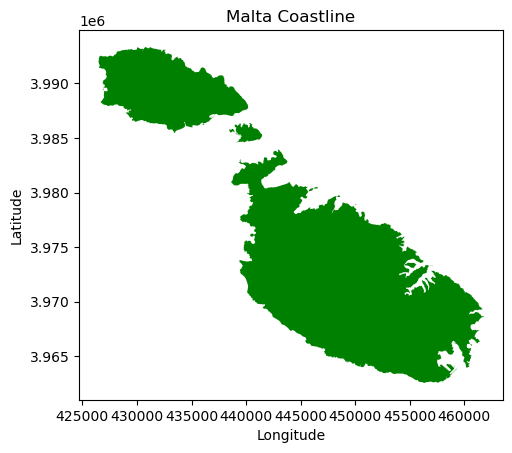

In [3]:
# Load the shapefile
shapefile_path = 'Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path)

# Plot the shapefile
gdf.plot(color='green')
plt.title('Malta Coastline')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Load Shapefile and Extract Coastline Boundaries

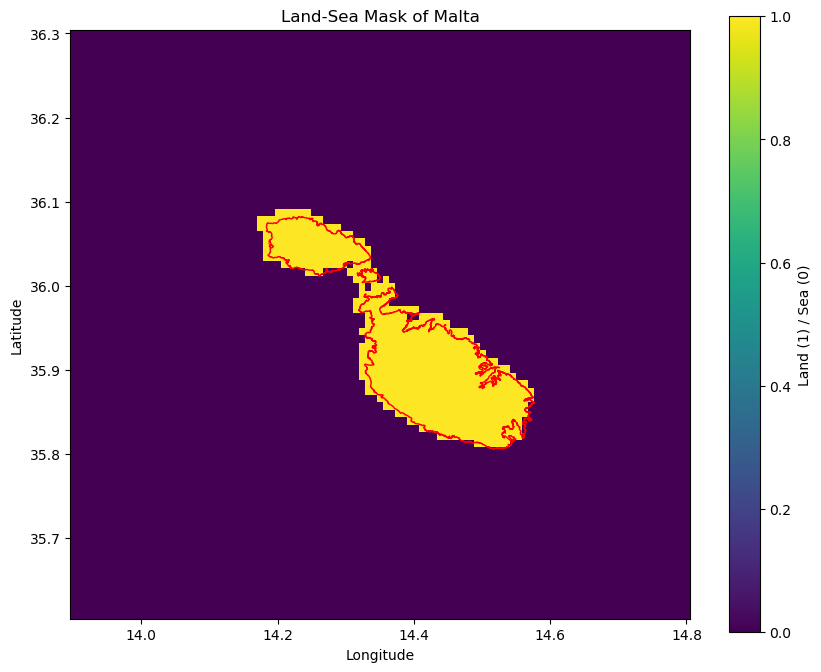

In [4]:
# Reproject to geographic coordinates (WGS 84)
gdf = gdf.to_crs(epsg=4326)

# Simulation bounds
lon_min, lat_min, lon_max, lat_max = 13.9, 35.6, 14.81, 36.3

# Define a finer resolution in kilometers
resolution_km = 0.8  # Finer resolution of 1 km

# Calculate the distance in degrees for the given resolution
mean_lat = (lat_min + lat_max) / 2
km_per_degree = np.cos(mean_lat * np.pi / 180) * 111.32  # Approximate conversion factor at this latitude
resolution_degrees = resolution_km / km_per_degree

# Calculate the number of grid cells at this new resolution
num_lons = int(np.ceil((lon_max - lon_min) / resolution_degrees))
num_lats = int(np.ceil((lat_max - lat_min) / resolution_degrees))

# Create the transformation from lat/lon to the grid
transform = rasterio.transform.from_origin(lon_min, lat_max, resolution_degrees, resolution_degrees)

# Rasterize the shapefile
raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(num_lats, num_lons),
    transform=transform,
    fill=0,  # Fill value for 'sea'
    all_touched=True
)

# Generate the grid of longitude and latitude values
lons = np.linspace(lon_min, lon_max, num_lons, endpoint=False)
lats = np.linspace(lat_max, lat_min, num_lats, endpoint=False)[::-1]  # Start from max latitude to min latitude

# Create an xarray Dataset for the land-sea mask
ds = xr.Dataset(
    {
        'land_sea_mask': (['lat', 'lon'], raster)
    },
    coords={
        'lon': lons,
        'lat': lats  
    }
)

# Save the dataset to a NetCDF file
nc_filename = "Data/land_sea_mask/land_sea_mask_malta.nc"
ds.to_netcdf(nc_filename)

# Plot the land-sea mask for verification
plt.figure(figsize=(10, 8))
plt.pcolormesh(lons, lats[::-1], raster, cmap='viridis')
plt.colorbar(label='Land (1) / Sea (0)')
plt.title('Land-Sea Mask of Malta')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the shapefile to verify alignment
gdf.plot(ax=plt.gca(), color='none', edgecolor='red')

plt.show()

In [5]:
# # Load the land-sea mask data from the NetCDF file
# nc_filename = "Data/land_sea_mask/land_sea_mask_malta.nc"
# landsea_data = xr.open_dataset(nc_filename)

# # Extract the land-sea mask variable
# land_sea_mask = landsea_data['land_sea_mask']

# # Plotting
# fig = plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# land_sea_mask.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='viridis')

# # Add coastlines for reference
# ax.coastlines(resolution='10m', color='red', linewidth=1)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_title('Land-Sea Mask of Malta')

# # Show the plot
# plt.show()

### Creating a FieldSet

In [6]:
fieldset = FieldSet.from_netcdf(
    filenames={
        "U": "Data/Processed_SSC_Data.nc",
        "V": "Data/Processed_SSC_Data.nc",
        "U_wind": "Data/Processed_Wind_Data.nc",
        "V_wind": "Data/Processed_Wind_Data.nc"
    },
    variables={
        "U": "u",
        "V": "v",
        "U_wind": "u10",
        "V_wind": "v10"
    },
    dimensions={
        "U": {"lon": "lon", "lat": "lat", "time": "time"},
        "V": {"lon": "lon", "lat": "lat", "time": "time"},
        "U_wind": {"lon": "longitude", "lat": "latitude", "time": "time"},
        "V_wind": {"lon": "longitude", "lat": "latitude", "time": "time"}
    },
    allow_time_extrapolation=True
)

# Load the land-sea mask data
landsea_data = xr.open_dataset("Data/land_sea_mask/land_sea_mask_malta.nc")

# Add the land-sea mask as a Field to the FieldSet
fieldset.add_field(Field('land_sea_mask', 
                         data=landsea_data['land_sea_mask'].values, 
                         lon=landsea_data['lon'].values, 
                         lat=landsea_data['lat'].values, 
                         mesh='spherical', 
                         interp_method='nearest'))

### Initializing the Particles

In [7]:
# Define polygon boundaries
boundaries = {
    'min_lon': 13.9, 'max_lon': 14.81,
    'min_lat': 35.6, 'max_lat': 36.3
}

# Adjusting the release points to be closer to the edges of the boundary
edge_buffer_lon = (boundaries['max_lon'] - boundaries['min_lon']) / 20  # 5% buffer from the longitude edges
edge_buffer_lat = (boundaries['max_lat'] - boundaries['min_lat']) / 20  # 5% buffer from the latitude edges

# Number of particles to release
num_particles = 20

# Generate positions close to the edges
lat_release_near_edges = np.concatenate([
    np.random.uniform(boundaries['min_lat'] + edge_buffer_lat, boundaries['min_lat'] + 2 * edge_buffer_lat, num_particles // 4),
    np.random.uniform(boundaries['max_lat'] - 2 * edge_buffer_lat, boundaries['max_lat'] - edge_buffer_lat, num_particles // 4)
])

lon_release_near_edges = np.concatenate([
    np.random.uniform(boundaries['min_lon'] + edge_buffer_lon, boundaries['min_lon'] + 2 * edge_buffer_lon, num_particles // 4),
    np.random.uniform(boundaries['max_lon'] - 2 * edge_buffer_lon, boundaries['max_lon'] - edge_buffer_lon, num_particles // 4)
])

# To ensure even distribution, shuffle the arrays
np.random.shuffle(lat_release_near_edges)
np.random.shuffle(lon_release_near_edges)

# Since we divided the particles into groups for each edge, we might need to adjust if num_particles is not a multiple of 4
# This is a simple fix to ensure we have exactly num_particles
lat_release = np.resize(lat_release_near_edges, num_particles)
lon_release = np.resize(lon_release_near_edges, num_particles)

### Define Simulation Parameters

In [8]:
# Define number of days for the simulation
runtime = timedelta(days=1046)  

#--------------------------------------------------------------------------------------------------------------------------

# Option 1: Fixed timestep (e.g., 10 minutes)
# dt = timedelta(minutes=12)

# Option 2: Timestep that aligns with your data intervals (e.g., 30 minutes or 1 hour)
#dt = timedelta(minutes=30)
dt = timedelta(hours=12)

# Option 3: If you want to use the exact timestep as your data
# dt = timedelta(hours=12)  # if your data interval is 12 hours

### Custom Kernels & Executing the Simulation

In [11]:
def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()
        
class ReflectiveParticle(JITParticle):
    # Adding variables for previous positions
    prev_lon = Variable('prev_lon', initial=fieldset.U.grid.lon[0])  # Initialize with the first longitude 
    prev_lat = Variable('prev_lat', initial=fieldset.U.grid.lat[0])  # Initialize with the first latitude 
    elapsed_time = Variable('elapsed_time', initial=0.)  # Elapsed time in seconds
    
# Custom kernel to update the elapsed time
def UpdateElapsedTime(particle, fieldset, time):
    particle.elapsed_time += math.fabs(particle.dt) / (3600 * 24)  # Convert seconds to days
    
def UpdatePreviousPosition(particle, fieldset, time):
    # Update the previous position with the current position before moving
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

def ReflectOnLand(particle, fieldset, time):
    if fieldset.land_sea_mask[particle] == 1:
        # Reflect the particle's position
        particle.lon = particle.prev_lon
        particle.lat = particle.prev_lat
        
# Create a ParticleSet with JITParticle positioned near the edges
pset = ParticleSet(fieldset=fieldset, pclass=ReflectiveParticle, lon=lon_release, lat=lat_release)

# Define a custom output file that will store the elapsed_time for each particle
class MyParticleFile(ParticleFile):
    def __init__(self, *args, **kwargs):
        super(MyParticleFile, self).__init__(*args, **kwargs)

    def write(self, pset, time):
        """Write out the elapsed_time for each particle"""
        super(MyParticleFile, self).write(pset, time)
        for particle in pset:
            self.dataset.variables['elapsed_time'][self.idx] = particle.elapsed_time
        self.idx += 1

# Execute the simulation
output_file = pset.ParticleFile(name="debris_simulation_output.zarr", outputdt=timedelta(minutes=720))  # Save output every hour

pset.execute(
    AdvectionRK4 + 
    pset.Kernel(UpdatePreviousPosition) + 
    pset.Kernel(ReflectOnLand) +
    pset.Kernel(UpdateElapsedTime) +
    pset.Kernel(CheckOutOfBounds) + 
    pset.Kernel(CheckError),
    runtime=runtime,
    dt=dt,
    output_file=output_file,
)

  5%|▌         | 43200.0/864000.0 [00:37<11:43, 1166.54it/s]  
INFO: Output files are stored in debris_simulation_output.zarr.
100%|██████████| 864000.0/864000.0 [00:04<00:00, 213741.78it/s]


### Visualise

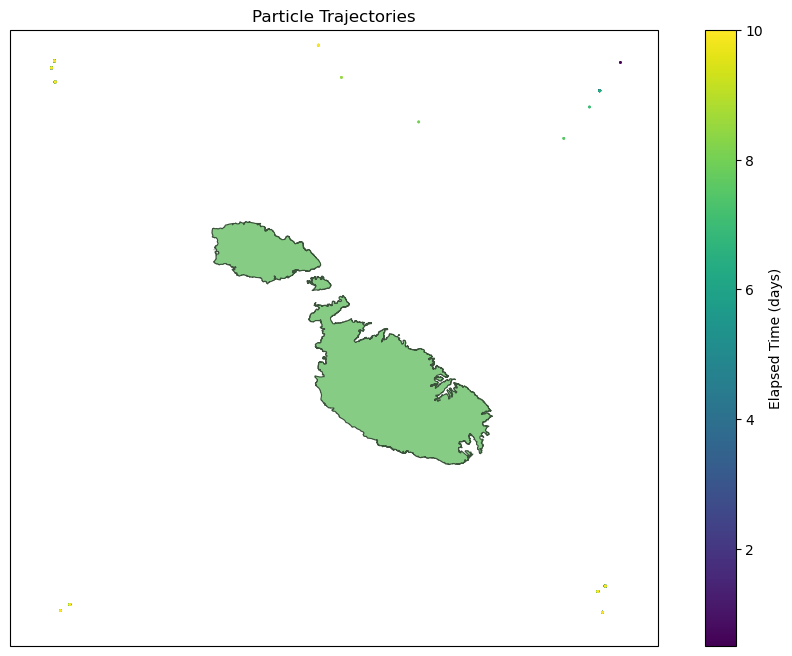

In [18]:
# Load the simulation output
ds = xr.open_zarr("debris_simulation_output.zarr")

# Load the shapefile with the map of Malta
malta_map = gpd.read_file('Data/land_sea_mask/MaltaCoastline.shp')

# Reproject to the same projection as the plot
malta_map = malta_map.to_crs(epsg=4326)

# Define the geographic boundaries
extent = [13.9, 14.81, 35.6, 36.3]

# Plot the particle trajectories with the improved coastline
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Overlay the map of Malta
malta_map.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=2) 

# Add the border of the map
ax.add_feature(cfeature.BORDERS, linestyle=':')

elapsed_time_flat = ds.elapsed_time.values.flatten()

# Plot the particle trajectories using 'elapsed_time' for color-coding
scatter = ax.scatter(ds.lon.values.flatten(), ds.lat.values.flatten(), s=1, c=elapsed_time_flat, cmap='viridis', marker='o', transform=ccrs.PlateCarree())

# Add a colorbar and labels
cbar = plt.colorbar(scatter, ax=ax, label='Elapsed Time (days)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Particle Trajectories')

plt.show()